In [1]:
!pip install albumentations wandb nbformat opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import nbformat
import cv2

from collections import Counter
import logging
import os

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


In [6]:
data_transforms = {
    "train": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.3),
        #A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.3, 0.3), p=0.3),
        #A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.2),
        A.GaussNoise(var_limit=(10, 50), p=0.1),
        A.CLAHE(clip_limit=(1,3), tile_grid_size=(8, 8), p=0.3),
        #A.RandomCrop(224, 224, 0.3),  # RandomCrop to introduce variability
        # A.CenterCrop(height=224, width=224, p=0.3),
        # choose mean and std based on pre-trained model specification.
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    "validation": A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    "test": A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
}


In [7]:
class CustomDataset(Dataset):
    def __init__(self, dir_root, split, transform=None, resize=None):
        self.dir_root = dir_root
        self.split = split
        self.transform = transform
        self.resize = resize
        self.data = []
        self.targets = []
        self.class_names = []

        data_dir = os.path.join(dir_root, split)

        class_directories = sorted(os.listdir(data_dir))
        for class_idx, class_dir in enumerate(class_directories):
            class_path = os.path.join(data_dir, class_dir)
            self.class_names.append(class_dir)

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.targets.append(class_idx)

        self.class_idx_to_name = {idx: name for idx, name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        target = self.targets[idx]

        try:
            image = cv2.imread(img_path)

            if self.resize:
                image = cv2.resize(image, (self.resize, self.resize))

            if self.transform:
                image = self.transform(image=image)['image']

            return image, target

        except Exception as e:
            print(f"Error loading image: {e}")
            return None, None

    def num_classes(self):
        return len(self.class_names)

    def get_class_name(self, class_idx):
        return self.class_idx_to_name.get(class_idx)

    def get_class_names(self):
        return self.class_names

    def class_idx_to_name_dict(self):
        return self.class_idx_to_name

    def get_classes_frequencies(self):
        return dict(Counter(self.targets))

In [8]:
data_directory = "/content/drive/MyDrive/original(resized)"

In [9]:
training_dataset = CustomDataset(dir_root=data_directory, split='train', transform=data_transforms['train'])
validation_dataset = CustomDataset(dir_root=data_directory, split='validation', transform=data_transforms['validation'])
test_dataset = CustomDataset(dir_root=data_directory, split='test', transform=data_transforms['test'])

In [10]:
print(training_dataset.num_classes())
print(training_dataset.get_class_names())
print(training_dataset.get_classes_frequencies())

8
['Anthracnose_Fungi', 'Bacterial_Wilt_Bacteria', 'Belly_Rot_Fungi', 'Downy_Mildew_Fungi', 'Gummy_Stem_Blight_Fungi', 'Healthy_Crop_Cucumber', 'Healthy_Crop_Leaf', 'Pythium_Fruit_Rot_Fungi']
{0: 128, 1: 128, 2: 128, 3: 128, 4: 128, 5: 128, 6: 128, 7: 135}


In [11]:
train_dataloader = DataLoader(training_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
in_features = model.fc.in_features

model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=in_features, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, training_dataset.num_classes()),
)

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [19]:
num_epochs = 30
lr = 0.001

model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
run = wandb.init(
    # Set the project where this run will be logged
    project="milan-project",
    notes="the model is resnet50; frozen; CALCULATE ENERGY; the last layer has even more complex architecture; data augmentation",
    save_code=False,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "architecture": "resnet50",
        "dataset": "augmented"
    },
)

wandb: Currently logged in as: prince_. Use `wandb login --relogin` to force relogin


In [21]:
wandb.watch(model, log="all")

[]

In [22]:
from tqdm import tqdm

In [23]:
def train_one_epoch(epoch, model, dataloader, criterion, optimizer, device):
    model.train()

    # if epoch == 6:
    #     for param in model.parameters():
    #         param.requires_grad = True

    running_loss = 0.0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss/len(dataloader)
    print(f"Epoch: [{epoch+1}], Training Loss: {avg_loss: .4f}")
    return avg_loss

def validation(epoch, model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Epoch: [{epoch+1}], Validation Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1


def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(training_dataset.num_classes()), yticklabels=range(training_dataset.num_classes()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show

    wandb.log({'test loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1 score': f1})
    print(f"Test Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1

In [24]:
import copy

f1_best = float('-inf')
best_model_state_dict = None
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, train_dataloader, criterion, optimizer, device)
    _, _, _, _, f1 = validation(epoch, model, val_dataloader, criterion, device)

    if f1 > f1_best:
        f1_best = f1
        best_model_state_dict = copy.deepcopy(model.state_dict())

if best_model_state_dict:
    model.load_state_dict(best_model_state_dict)

100%|██████████| 65/65 [05:28<00:00,  5.06s/it]

Epoch: [1], Training Loss:  1.3724



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: [1], Validation Loss:  0.8384, Accuracy:  0.5938, Precision:  0.6345, Recall:  0.5938, F1 Score:  0.5416


100%|██████████| 65/65 [00:08<00:00,  8.02it/s]

Epoch: [2], Training Loss:  0.8403


Epoch: [2], Validation Loss:  0.6040, Accuracy:  0.7578, Precision:  0.8306, Recall:  0.7578, F1 Score:  0.7233


100%|██████████| 65/65 [00:10<00:00,  6.28it/s]

Epoch: [3], Training Loss:  0.7075


Epoch: [3], Validation Loss:  0.4948, Accuracy:  0.8203, Precision:  0.8392, Recall:  0.8203, F1 Score:  0.8102


100%|██████████| 65/65 [00:08<00:00,  7.33it/s]

Epoch: [4], Training Loss:  0.5794


Epoch: [4], Validation Loss:  0.3722, Accuracy:  0.8594, Precision:  0.8663, Recall:  0.8594, F1 Score:  0.8586


100%|██████████| 65/65 [00:08<00:00,  7.99it/s]

Epoch: [5], Training Loss:  0.5323


Epoch: [5], Validation Loss:  0.3966, Accuracy:  0.8594, Precision:  0.8672, Recall:  0.8594, F1 Score:  0.8474


100%|██████████| 65/65 [00:10<00:00,  6.22it/s]

Epoch: [6], Training Loss:  0.5035


Epoch: [6], Validation Loss:  0.3188, Accuracy:  0.8828, Precision:  0.8960, Recall:  0.8828, F1 Score:  0.8861


100%|██████████| 65/65 [00:08<00:00,  7.35it/s]


Epoch: [7], Training Loss:  0.5526
Epoch: [7], Validation Loss:  0.3665, Accuracy:  0.8281, Precision:  0.8614, Recall:  0.8281, F1 Score:  0.8250


100%|██████████| 65/65 [00:08<00:00,  7.79it/s]

Epoch: [8], Training Loss:  0.4964


Epoch: [8], Validation Loss:  0.5708, Accuracy:  0.8125, Precision:  0.8487, Recall:  0.8125, F1 Score:  0.7957


100%|██████████| 65/65 [00:10<00:00,  6.39it/s]

Epoch: [9], Training Loss:  0.5089


Epoch: [9], Validation Loss:  0.3545, Accuracy:  0.8672, Precision:  0.9281, Recall:  0.8672, F1 Score:  0.8703


100%|██████████| 65/65 [00:08<00:00,  7.57it/s]

Epoch: [10], Training Loss:  0.4669


Epoch: [10], Validation Loss:  0.3370, Accuracy:  0.8672, Precision:  0.8945, Recall:  0.8672, F1 Score:  0.8718


100%|██████████| 65/65 [00:08<00:00,  7.91it/s]

Epoch: [11], Training Loss:  0.4668


Epoch: [11], Validation Loss:  0.2754, Accuracy:  0.8984, Precision:  0.8979, Recall:  0.8984, F1 Score:  0.8966


100%|██████████| 65/65 [00:10<00:00,  6.36it/s]

Epoch: [12], Training Loss:  0.4657


Epoch: [12], Validation Loss:  0.2845, Accuracy:  0.8984, Precision:  0.9003, Recall:  0.8984, F1 Score:  0.8966


100%|██████████| 65/65 [00:08<00:00,  7.73it/s]

Epoch: [13], Training Loss:  0.4183


Epoch: [13], Validation Loss:  0.3139, Accuracy:  0.8750, Precision:  0.8799, Recall:  0.8750, F1 Score:  0.8731


100%|██████████| 65/65 [00:08<00:00,  7.77it/s]

Epoch: [14], Training Loss:  0.4465


Epoch: [14], Validation Loss:  0.3214, Accuracy:  0.8828, Precision:  0.8854, Recall:  0.8828, F1 Score:  0.8805


100%|██████████| 65/65 [00:10<00:00,  5.96it/s]

Epoch: [15], Training Loss:  0.4067


Epoch: [15], Validation Loss:  0.3730, Accuracy:  0.8359, Precision:  0.8602, Recall:  0.8359, F1 Score:  0.8198


100%|██████████| 65/65 [00:09<00:00,  7.00it/s]

Epoch: [16], Training Loss:  0.3991


Epoch: [16], Validation Loss:  0.3260, Accuracy:  0.8672, Precision:  0.8799, Recall:  0.8672, F1 Score:  0.8664


100%|██████████| 65/65 [00:08<00:00,  7.26it/s]

Epoch: [17], Training Loss:  0.4226


Epoch: [17], Validation Loss:  0.2779, Accuracy:  0.8984, Precision:  0.9023, Recall:  0.8984, F1 Score:  0.8985


100%|██████████| 65/65 [00:09<00:00,  6.72it/s]

Epoch: [18], Training Loss:  0.3239


Epoch: [18], Validation Loss:  0.3345, Accuracy:  0.8828, Precision:  0.8920, Recall:  0.8828, F1 Score:  0.8771


100%|██████████| 65/65 [00:10<00:00,  6.37it/s]

Epoch: [19], Training Loss:  0.3306


Epoch: [19], Validation Loss:  0.2774, Accuracy:  0.8906, Precision:  0.8923, Recall:  0.8906, F1 Score:  0.8867


100%|██████████| 65/65 [00:07<00:00,  8.23it/s]

Epoch: [20], Training Loss:  0.3208


Epoch: [20], Validation Loss:  0.3086, Accuracy:  0.8750, Precision:  0.8805, Recall:  0.8750, F1 Score:  0.8707


100%|██████████| 65/65 [00:10<00:00,  6.19it/s]

Epoch: [21], Training Loss:  0.4366


Epoch: [21], Validation Loss:  0.2734, Accuracy:  0.8984, Precision:  0.9123, Recall:  0.8984, F1 Score:  0.9005


100%|██████████| 65/65 [00:09<00:00,  6.95it/s]

Epoch: [22], Training Loss:  0.3827


Epoch: [22], Validation Loss:  0.3536, Accuracy:  0.8906, Precision:  0.8981, Recall:  0.8906, F1 Score:  0.8823


100%|██████████| 65/65 [00:07<00:00,  8.25it/s]

Epoch: [23], Training Loss:  0.3057


Epoch: [23], Validation Loss:  0.3006, Accuracy:  0.8984, Precision:  0.8980, Recall:  0.8984, F1 Score:  0.8926


100%|██████████| 65/65 [00:10<00:00,  6.39it/s]

Epoch: [24], Training Loss:  0.4111


Epoch: [24], Validation Loss:  0.2933, Accuracy:  0.8750, Precision:  0.8803, Recall:  0.8750, F1 Score:  0.8743


100%|██████████| 65/65 [00:09<00:00,  6.80it/s]

Epoch: [25], Training Loss:  0.3485


Epoch: [25], Validation Loss:  0.2543, Accuracy:  0.9219, Precision:  0.9246, Recall:  0.9219, F1 Score:  0.9209


100%|██████████| 65/65 [00:07<00:00,  8.13it/s]

Epoch: [26], Training Loss:  0.3052


Epoch: [26], Validation Loss:  0.2740, Accuracy:  0.8828, Precision:  0.8930, Recall:  0.8828, F1 Score:  0.8838


100%|██████████| 65/65 [00:10<00:00,  6.34it/s]

Epoch: [27], Training Loss:  0.3926


Epoch: [27], Validation Loss:  0.3356, Accuracy:  0.8672, Precision:  0.8756, Recall:  0.8672, F1 Score:  0.8643


100%|██████████| 65/65 [00:09<00:00,  6.84it/s]

Epoch: [28], Training Loss:  0.3163


Epoch: [28], Validation Loss:  0.3040, Accuracy:  0.8828, Precision:  0.8859, Recall:  0.8828, F1 Score:  0.8811


100%|██████████| 65/65 [00:07<00:00,  8.20it/s]

Epoch: [29], Training Loss:  0.3905


Epoch: [29], Validation Loss:  0.2946, Accuracy:  0.8984, Precision:  0.9076, Recall:  0.8984, F1 Score:  0.8994


100%|██████████| 65/65 [00:10<00:00,  6.43it/s]

Epoch: [30], Training Loss:  0.3813


Epoch: [30], Validation Loss:  0.3383, Accuracy:  0.8828, Precision:  0.8892, Recall:  0.8828, F1 Score:  0.8818


Test Loss:  0.1404, Accuracy:  0.9385, Precision:  0.9417, Recall:  0.9385, F1 Score:  0.9369


(0.14037987077608705,
 0.9384615384615385,
 0.9416607128681432,
 0.9384615384615385,
 0.936936396936397)

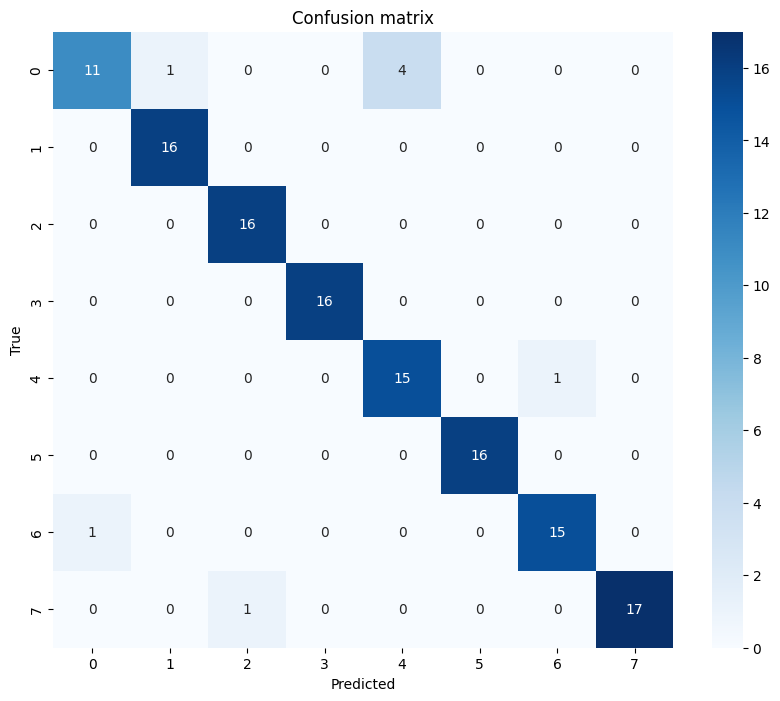

In [25]:
test(model, test_dataloader, criterion, device)

## Out-of-Distribution Detection

In [26]:
import numpy as np

def calculate_energy(outputs):
    return -torch.logsumexp(outputs, dim=1)

def analyze_energy_distribution(model, dataloader, device):
    model.eval()
    energies = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            energy = calculate_energy(outputs)
            energies.extend(energy.cpu().numpy())
    return energies

energies = analyze_energy_distribution(model, train_dataloader, device)

energy_threshold = np.percentile(energies, 95)

print(f"Energy Threshold: {energy_threshold}")

Energy Threshold: -3.025323987007141


In [27]:
model_name = 'resnet50.pth'

torch.save(model.state_dict(), model_name)
model_artifact = wandb.Artifact('model', type='model')
model_artifact.add_file(model_name)

ArtifactManifestEntry(path='resnet50.pth', digest='zWcp49CrKKD09q7h3X87EA==', size=99614770, local_path='/root/.local/share/wandb/artifacts/staging/tmpqiat6ngn', skip_cache=False)

In [28]:
wandb.log_artifact(model_artifact)

<Artifact model>

In [29]:
import numpy as np

def inference(model, image_path, device):
    image = Image.open(image_path)

    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    image = transform(image=np.array(image))['image']
    image_tr = torch.tensor(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(image_tr)
        energy = calculate_energy(output)
        if energy > energy_threshold:
            print(f"The class is of unknown origin")
            print(f"Its energy is {energy}, but the threshold is {energy_threshold}")
            return
        prob = torch.softmax(output, dim=1)
        s, predicted_class = torch.max(prob,  1)
        print(f"Probability: {s}")
        print(f"Predicted class: {predicted_class}")
        print("-------------------------------------\n")
        return s

tests_dir = "/content/drive/MyDrive/test images"

avg = []

for filename in os.listdir(tests_dir):
    image_path = os.path.join(tests_dir, filename)
    inference(model, image_path, device)
    # avg.append(torch.tensor(s, dtype=torch.float32))

# avg = torch.cat(avg)

# print(f"Avergae predicted probability: {torch.mean(avg)}")


<ipython-input-29-5163442a5a24>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tr = torch.tensor(image).unsqueeze(0).to(device)


The class is of unknown origin
Its energy is tensor([-2.4298], device='cuda:0'), but the threshold is -3.025323987007141
The class is of unknown origin
Its energy is tensor([-1.7337], device='cuda:0'), but the threshold is -3.025323987007141
The class is of unknown origin
Its energy is tensor([-1.5688], device='cuda:0'), but the threshold is -3.025323987007141
The class is of unknown origin
Its energy is tensor([-1.7031], device='cuda:0'), but the threshold is -3.025323987007141
The class is of unknown origin
Its energy is tensor([-1.5749], device='cuda:0'), but the threshold is -3.025323987007141
The class is of unknown origin
Its energy is tensor([-1.5004], device='cuda:0'), but the threshold is -3.025323987007141
The class is of unknown origin
Its energy is tensor([-2.7268], device='cuda:0'), but the threshold is -3.025323987007141
Probability: tensor([0.4707], device='cuda:0')
Predicted class: tensor([6], device='cuda:0')
-------------------------------------

The class is of unkno

In [30]:
tests_dir = "/content/drive/MyDrive/original(resized)/test/Anthracnose_Fungi"

avg = []
for filename in os.listdir(tests_dir):
    image_path = os.path.join(tests_dir, filename)
    inference(model, image_path, device)
#     avg.append(torch.tensor(s, dtype=torch.float32))

# avg = torch.cat(avg)

# print(f"Avergae predicted probability: {torch.mean(avg)}")

<ipython-input-29-5163442a5a24>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tr = torch.tensor(image).unsqueeze(0).to(device)


Probability: tensor([0.5263], device='cuda:0')
Predicted class: tensor([4], device='cuda:0')
-------------------------------------

Probability: tensor([0.9750], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

Probability: tensor([0.7784], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

Probability: tensor([0.5912], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-2.9701], device='cuda:0'), but the threshold is -3.025323987007141
Probability: tensor([0.9383], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

Probability: tensor([0.6378], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-2.3607], device='cuda:0'), but th

In [ ]:
notebook_name = "/content/drive/MyDrive/Colab Notebooks/NN_resnet18_aug.ipynb"
with open(notebook_name) as f:
    nb = nbformat.read(f, as_version=4)
artifact = wandb.Artifact('notebook', type='notebook')
artifact.add_file(notebook_name)
wandb.log_artifact(artifact)

<Artifact notebook>

In [ ]:
wandb.finish()

accuracy,▁
f1 score,▁
precision,▁
recall,▁
test loss,▁
accuracy,0.90769
f1 score,0.90614
precision,0.91284
recall,0.90769
test loss,0.15714
